### BIBLIOTECAS/PACOTES:
* São importadas as bibliotecas que serão usadas durante o código (maioria delas);


In [2]:
import pandas as pd
import re
import nltk
import unicodedata
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

### PRE-PROCESSAMENTO:
* Strip_accents() - retira acentuação das palavras;
* Text_process() - etapa de pre-processamento dos textos;
* plot_confusion_matrix() - plot da matriz de confusão (etapa de classificação);
* process_predict() - etapa de pre-processamento para somente um texto (para predição).

In [3]:
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFKD', s)
                  if unicodedata.category(c) != 'Mn')

def text_process(data):
    corpus=[]
    for text in data:
        text=re.sub("[^a-zA-Z]"," ", text)   
        text=text.lower()
        text=strip_accents(text)
        ps = PorterStemmer()
        word=[str(ps.stem(word)) for word in text.split() if word not in set(stopwords.words('english'))]
        word = ' '.join(word)
        corpus.append(word)
    
    return corpus

#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=8)
    plt.yticks(tick_marks, classes,fontsize=8)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=10)
    plt.xlabel('Predicted label',fontsize=10)
    
def process_predict(text):
    corpus=[]
    text=re.sub("[^a-zA-Z]"," ", text)   
    text=text.lower()
    text=strip_accents(text)
    ps = PorterStemmer()
    word=[str(ps.stem(word)) for word in text.split() if word not in set(stopwords.words('english'))]
    word = ' '.join(word)
    corpus.append(word)
    return corpus

### LEITURA DOS DADOS:
* Abre o arquivo .tsv (campos são separados por tab (\t));
* Troca os dados da coluna Liked por NEGATIVO (valor 0) e POSITIVO valor(1).

In [4]:
data = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)
data['Liked'] = data['Liked'].map({0:'NEGATIVE',1:'POSITIVE'})

In [5]:
data.head(20)

,Review,Liked
0,Wow... Loved this place.,POSITIVE
1,Crust is not good.,NEGATIVE
2,Not tasty and the texture was just nasty.,NEGATIVE
3,Stopped by during the late May bank holiday of...,POSITIVE
4,The selection on the menu was great and so wer...,POSITIVE
5,Now I am getting angry and I want my damn pho.,NEGATIVE
6,Honeslty it didn't taste THAT fresh.),NEGATIVE
7,The potatoes were like rubber and you could te...,NEGATIVE
8,The fries were great too.,POSITIVE
9,A great touch.,POSITIVE


### GRÁFICOS:
* Alguns gráficos que podem ser interessantes para ter maior informação sobre o problema.
* Quantidade de reviews POSITIVOS e NEGATIVOS!
* Informação sobre o tamanho médio dos reviews!
    

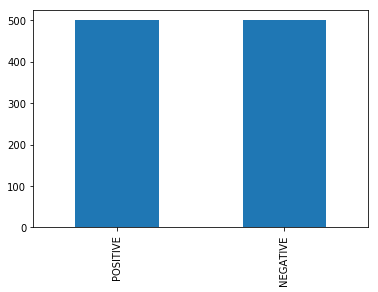

In [6]:
label_distribution=data['Liked'].value_counts()
label_distribution.plot(kind='bar')
data=data[['Review','Liked']]
plt.show()

In [7]:
data['Length'] = data['Review'].apply(len)
data.head(20)

,Review,Liked,Length
0,Wow... Loved this place.,POSITIVE,24
1,Crust is not good.,NEGATIVE,18
2,Not tasty and the texture was just nasty.,NEGATIVE,41
3,Stopped by during the late May bank holiday of...,POSITIVE,87
4,The selection on the menu was great and so wer...,POSITIVE,59
5,Now I am getting angry and I want my damn pho.,NEGATIVE,46
6,Honeslty it didn't taste THAT fresh.),NEGATIVE,37
7,The potatoes were like rubber and you could te...,NEGATIVE,111
8,The fries were great too.,POSITIVE,25
9,A great touch.,POSITIVE,14


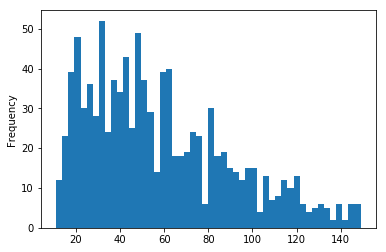

In [8]:
data['Length'].plot(bins=50, kind='hist')

### PERGUNTA:
* Será que existe alguma relação entre o tamanho do review e o fato de ser POSITIVO ou NEGATIVO?

#### PASSOS:
* Verificar os dados estatísticos sobre o tamanho: máximo (max), mínimo (min), desvio(std), média (mean);
* Agrupar os dados conforme a coluna de classificação do Review (Liked).

In [9]:
data.Length.describe()

count    1000.000000
mean       58.315000
std        32.360052
min        11.000000
25%        33.000000
50%        51.000000
75%        80.000000
max       149.000000
Name: Length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019D39A86630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000019D39660550>], dtype=object)

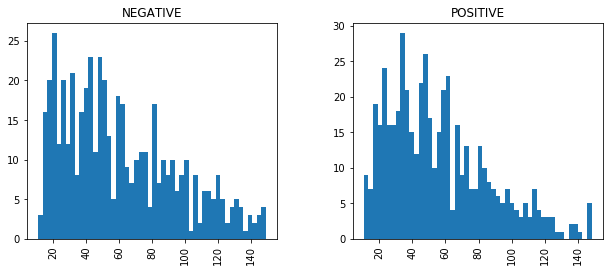

In [10]:
data.hist(column='Length', by='Liked', bins=50,figsize=(10,4))

### PASSOS PARA DESENVOLVER UM ALGORITMO DE MACHINE LEARNING:
* Coletar (Obter) os dados;
* Pre-processar os dados para deixar em um formato que o classificador entenda;
* Dividir em Conjunto de treinamento e teste;
* Avaliar o desempenho do seu algoritmo treinado no conjunto de treinamento para o conjunto de teste;
* Tenta melhorar o desempenho mudando hiperparamêtros ou trocando o classificador ou mudando etapas de pre-processamento.

![title](machine_learning.png)

* LINK:
* http://upxacademy.com/introduction-machine-learning/

### PRE-PROCESSAMENTO + BAG OF WORDS:
* Aplica o método de pre-processamento de texto para todos os textos da coluna Review;
* Usa o CountVectorizer() para transformar um conjunto de texto em uma matriz de TOKENS;
* X é o bag of words (variável independente);
* Y é o classificação do Review (variável dependente).


In [11]:
texts=text_process(data['Review'])

cv = CountVectorizer()
X = cv.fit_transform(texts).toarray()
y = data.iloc[:, 1].values

             
vocab = cv.get_feature_names()           
bag_of_words=pd.DataFrame(data=X, columns=vocab)

bag_of_words.head(20)

,absolut,absolutley,accid,accommod,accomod,accordingli,account,ach,acknowledg,across,...,year,yellow,yellowtail,yelper,yet,yucki,yukon,yum,yummi,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


![title](bag_of_words.png)

* LINK:
* http://datameetsmedia.com/bag-of-words-tf-idf-explained/

### CONJUNTO DE TREINAMENTO E TESTE:
* Dividir o X e Y em conjunto de treinamento e teste;
* Conjunto de Treinamento: conjunto de instâncias (dados) que você TREINA o seu modelo;
* Conjunto de Testes: conjunto de instâncias (dados) que você TESTA seu modelo;
* Objetivo: avaliar a capacidade de predição do seu modelo para um conjunto de testes(dados que o classificador não viu antes).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

dict_class={}

### MÉTRICAS DE AVALIAÇÃO:

![title](confusion_matrix.png)

#### ACERTOS:
* True Positives (TP) - valores preditos são corretamente classificados como positivos;
* True Negative (TN) - valores preditos são corretamente classificados como negativos;

#### ERROS:
* False Positive (FP) - Valor real é NÃO (falso) e foi predito SIM (verdadeiro);
* False Negative (FN) - Valor real é SIM (verdadeiro) e foi predito Não (falso);



* LINK:
* http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/


#### ACCURACY PROBLEM:

![title](accuracy_mistakes.png)

* 99.9% de acurácia, porém acertou somente 50% quando a label era positiva!
* Acurácia é uma boa medida quando se tem datasets simétricos onde os valores dos FP e FN são parecidos (classes não balanceadas).

#### ACCURACY:
* Percentual de predições corretas em relação ao total de observações;
* (TP + TN)/(TP +FP +FN +TN)

#### PRECISION:
* Proporção de observações corretas positivas em relação ao total de observações positivas preditas;
* TP/(TP+ FP);
* Quanto das suas previsões são realmente positivas.

#### RECALL:
* Proporção de observações corretas positivas em relação ao total de observações reais para a classe;
* TP/ (TP +FN);
* Calcula quanto de valores reais positivos nosso modelo consegue classificar como positivo (TP);
* Medida usada para selecionar nosso modelo quando existe um custo alto com FN (exemplo: detecção de fraudes, detecção de pacientes doentes).

#### F1 SCORE:
* Média (valor médio) entre Precision and Recall;
* Leva em conta os FP e FN;
* Mais útil que accuracy principalmente com classes não balanceadas;


![title](confusion_matrixv2.png)

* LINK:
* http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
* https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9



### CLASSIFICADORES:
* Testar vários classificadores e verificar o desempenho pela acurácia, f1-score e matriz de confusão.
* Alguns algoritmos de classificação testados: 
    - Gaussian Naive Bayes;
    - Random Forest;
    - Support Vector Machine;
    - Multinomial Naive Bayes.


##### GAUSSIAN NAIVE BAYES:

In [13]:
from sklearn.naive_bayes import GaussianNB

classifier_gaussian = GaussianNB()
classifier_gaussian.fit(X_train, y_train)

y_pred = classifier_gaussian.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

Predicted  NEGATIVE  POSITIVE
Actual                       
NEGATIVE         55        42
POSITIVE         12        91


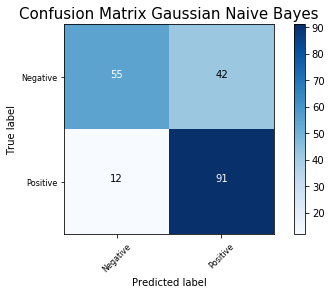

In [14]:
plt.figure()
plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                      title='Confusion Matrix Gaussian Naive Bayes')

In [15]:
print ('Classification Report:\n',classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test,y_pred))
print('\nF1-score:', f1_score(y_test, y_pred,  average='weighted'))

dict_class['Gaussian NB'] = accuracy_score(y_test,y_pred)


Classification Report:
              precision    recall  f1-score   support

   NEGATIVE       0.82      0.57      0.67        97
   POSITIVE       0.68      0.88      0.77       103

avg / total       0.75      0.73      0.72       200

Accuracy: 0.73

F1-score: 0.722465894998


##### RANDOM FOREST:

In [16]:
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)



y_pred = forest.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

Predicted  NEGATIVE  POSITIVE
Actual                       
NEGATIVE         86        11
POSITIVE         45        58


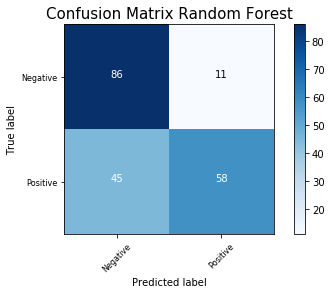

In [17]:
plt.figure()
plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                      title='Confusion Matrix Random Forest')


In [18]:
print ('Classification Report:\n',classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test,y_pred))
print('\nF1-score:', f1_score(y_test, y_pred,  average='weighted'))

dict_class['Random Forest'] = accuracy_score(y_test,y_pred)

Classification Report:
              precision    recall  f1-score   support

   NEGATIVE       0.66      0.89      0.75        97
   POSITIVE       0.84      0.56      0.67       103

avg / total       0.75      0.72      0.71       200

Accuracy: 0.72

F1-score: 0.713202774378


##### MULTINOMIAL NAIVE BAYES:

In [19]:
from sklearn.naive_bayes import MultinomialNB



classifier_bayes = MultinomialNB()
classifier_bayes.fit(X_train, y_train)

y_pred = classifier_bayes.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)





Predicted  NEGATIVE  POSITIVE
Actual                       
NEGATIVE         72        25
POSITIVE         22        81


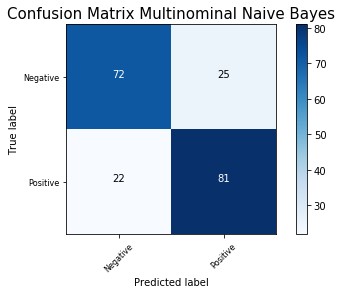

In [20]:
plt.figure()
plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                      title='Confusion Matrix Multinominal Naive Bayes')

In [21]:
print ('Classification Report:\n',classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test,y_pred))
print('\nF1-score:', f1_score(y_test, y_pred,  average='weighted'))

dict_class['Multinominal NB'] = accuracy_score(y_test,y_pred)

Classification Report:
              precision    recall  f1-score   support

   NEGATIVE       0.77      0.74      0.75        97
   POSITIVE       0.76      0.79      0.78       103

avg / total       0.77      0.77      0.76       200

Accuracy: 0.765

F1-score: 0.764841053133


##### SUPPORT VECTOR MACHINE:

In [22]:
from sklearn.svm import SVC


classifier_svm = SVC(kernel='linear',C=1)
classifier_svm.fit(X_train, y_train)

y_pred = classifier_svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)


Predicted  NEGATIVE  POSITIVE
Actual                       
NEGATIVE         74        23
POSITIVE         33        70


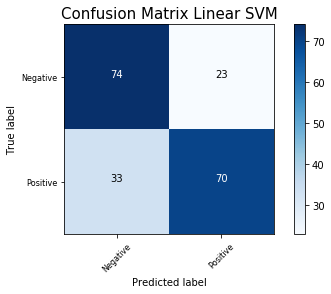

In [23]:
plt.figure()
plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                      title='Confusion Matrix Linear SVM')

In [24]:
print ('Classification Report:\n',classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test,y_pred))
print('\nF1-score:', f1_score(y_test, y_pred,  average='weighted'))

dict_class['Linear SVM'] = accuracy_score(y_test,y_pred)

Classification Report:
              precision    recall  f1-score   support

   NEGATIVE       0.69      0.76      0.73        97
   POSITIVE       0.75      0.68      0.71       103

avg / total       0.72      0.72      0.72       200

Accuracy: 0.72

F1-score: 0.719719887955


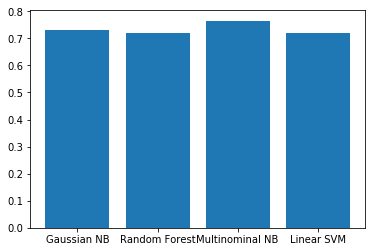

In [25]:
classifiers = list(dict_class.keys())
accuracy = list(dict_class.values())

plt.bar(left=range(len(dict_class)),height=accuracy,tick_label=classifiers)
plt.show()

### TESTES PARA O MODELO:
* Inserindo 2 frases (1 NEGATIVA e 1 POSITIVA) qual será o resultado da predição para Multinominal Naive Bayes (nosso melhor modelo até agora)?

In [26]:
text_spam='Really loved my trip'
print('POSITIVE TEXT: ',text_spam)
processed_spam = process_predict(text_spam)
X_spam = cv.transform(processed_spam).toarray()
pred_spam = classifier_bayes.predict(X_spam)
print('PREDICTION: ',pred_spam[0])

POSITIVE TEXT:  Really loved my trip
PREDICTION:  POSITIVE


In [28]:
text_ham = 'Waste of money and time'
print('TEXT NEG: ',text_ham)
processed_ham=process_predict(text_ham)
X_ham = cv.transform(processed_ham).toarray()
pred_ham = classifier_bayes.predict(X_ham)
print('PREDICTION: ',pred_ham[0])

TEXT NEG:  Waste of money and time
PREDICTION:  NEGATIVE


### SELEÇÃO DOS MELHORES HIPER PARÂMETROS PARA O ALGORITMO:
* Todos os exemplos foram rodados com parâmetros Default (padrão);
* Sempre é interessante rodar o algoritmo com os melhores hiperparâmetros.

* Como é possível selecionar os melhores parâmetros de um algoritmo?

#####  SVM KERNELS:
* Pela ordem na figura : SVM LINEAR, SVM POLY, SVM RBF

![title](svm_kernels.png)

* LINK:
* http://python.astrotech.io/machine-learning/support-vector-machines.html

In [30]:
from sklearn.grid_search import GridSearchCV

parameter_grid = [
  {'C': [1,10,100,1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'degree':[2,3,4], 'kernel': ['poly']}
]

clf = GridSearchCV(estimator=SVC(), param_grid=parameter_grid,cv=10, n_jobs=-1)
clf.fit(X, y)

print('Grid Scores:\n',clf.grid_scores_)
best_score=clf.best_score_
best_params=clf.best_params_
best_estimator=clf.best_estimator_
print('Best score:\n ', clf.best_score_)
print('Best params:\n ', clf.best_params_)
print('Best estimator:\n ', clf.best_estimator_)

Grid Scores:
 [mean: 0.77700, std: 0.04026, params: {'C': 1, 'kernel': 'linear'}, mean: 0.76300, std: 0.02968, params: {'C': 10, 'kernel': 'linear'}, mean: 0.74800, std: 0.03156, params: {'C': 100, 'kernel': 'linear'}, mean: 0.71900, std: 0.02982, params: {'C': 1000, 'kernel': 'linear'}, mean: 0.57700, std: 0.04859, params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.57700, std: 0.04859, params: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.69100, std: 0.03562, params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.57700, std: 0.04859, params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.78100, std: 0.04571, params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.69200, std: 0.03400, params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.77100, std: 0.03590, params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.78000, std: 0.04754, params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.52600, std: 0.02010, params: {'C': 1, 'degree':

### TESTE COM OS MELHORES PARÂMETROS PARA O SVM:
* Utilizar os resultados do GridSearch;
* Cross-Validation 10-fold;
* Medir a acurácia e f1-score.

![title](cross_val_score.png)

### CROSS-VALIDATION:
* Esquemático do que é cross-validation;
* Vantagens: medida mais exata do seu modelo;
* Desvantagem: leva mais tempo para rodar.

![title](cross_val.png)

* LINKS:
* https://www.kaggle.com/dansbecker/cross-validation
* https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
* https://www.youtube.com/watch?v=L_dQrZZjGDg



In [31]:
from sklearn.model_selection import cross_val_predict,cross_val_score

classifier_svm_cross = SVC(kernel='rbf',C=100,gamma=0.001)

scores_SVM= cross_val_score(clf.best_estimator_,X, y, scoring='accuracy', cv=10)
print("Accuracies: " + str(scores_SVM))
print("\nAccuracy for SVM:  %0.2f +/- %0.2f \n" % (scores_SVM.mean(), scores_SVM.std()*2))


Accuracies: [ 0.7   0.77  0.77  0.82  0.72  0.82  0.82  0.79  0.75  0.85]

Accuracy for SVM:  0.78 +/- 0.09 




F1-score: 0.780182057436


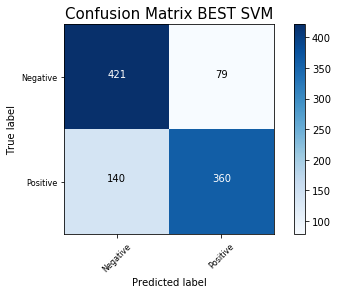

In [32]:
y_pred_SVM_cross = cross_val_predict(clf.best_estimator_, X, y, cv=10) # 10 CV
cm = confusion_matrix(y, y_pred_SVM_cross)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                      title='Confusion Matrix BEST SVM')

print('\nF1-score:', f1_score(y, y_pred_SVM_cross,  average='weighted'))

### VERIFICAÇÃO DAS PALAVRAS (TOKENS) QUE MAIS INFLUENCIAM A CLASSIFICAÇÃO:
* Utiliza o método show_most_informative_features() do Naive Bayes do NLTK (não tem esse método no scikit-learn);
* É possível verificar quais palavras (tokens) mais influenciam (para Naive Bayes) na hora de classificar como POSITIVO ou NEGATIVO.


In [33]:
train=data.values.tolist()

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer() 
all_words = set(str(ps.stem(word)).lower() for passage in train for word in word_tokenize(passage[0]))
t = [({word: (word in word_tokenize(x[0])) for word in all_words}, x[1]) for x in train]


classifier = nltk.NaiveBayesClassifier.train(t)
classifier.show_most_informative_features(20)

Most Informative Features
                      no = True           NEGATI : POSITI =     12.3 : 1.0
                    much = True           NEGATI : POSITI =      6.2 : 1.0
                    cold = True           NEGATI : POSITI =      5.7 : 1.0
                   worst = True           NEGATI : POSITI =      5.7 : 1.0
                    nice = True           POSITI : NEGATI =      5.3 : 1.0
                      do = True           NEGATI : POSITI =      5.2 : 1.0
                       $ = True           NEGATI : POSITI =      5.0 : 1.0
                    give = True           NEGATI : POSITI =      5.0 : 1.0
                    beer = True           POSITI : NEGATI =      5.0 : 1.0
                     bit = True           NEGATI : POSITI =      5.0 : 1.0
                     not = True           NEGATI : POSITI =      4.9 : 1.0
                   never = True           NEGATI : POSITI =      4.4 : 1.0
                       5 = True           POSITI : NEGATI =      4.3 : 1.0

### STOPWORDS:
* Será que a nossa lista de stopwords é adequada?
* As palavras "No", "Not" são grande indicadores de opinião NEGATIVA porém são retiradas na nossa lista de stopwords.


In [34]:
print('"No" in stopwords?', 'no' in stopwords.words('english'))
print('"Never" in stopwords?', 'never' in stopwords.words('english'))
print('"Not" in stopwords?', 'not' in stopwords.words('english'))
print('"Nice" in stopwords?', 'nice' in stopwords.words('english'))
print('"Much" in stopwords?', 'much' in stopwords.words('english'))

"No" in stopwords? True
"Never" in stopwords? False
"Not" in stopwords? True
"Nice" in stopwords? False
"Much" in stopwords? False


### TENTATIVA PARA MELHORAR O MODELO:
* Testar sem qualquer lista de stopword;
* Outras opções de teste: deixar caracteres especiais, deixar somente ALGUNS caracteres especiais.

In [35]:
def text_process_stopword(data):
    corpus=[]
    for text in data:
        text=re.sub("[^a-zA-Z]"," ", text)   
        text=text.lower()
        text=strip_accents(text)
        ps = PorterStemmer()
        word=[str(ps.stem(word)) for word in text.split()]
        word = ' '.join(word)
        corpus.append(word)
    
    return corpus

text_stop=text_process_stopword(data['Review'])

cv = CountVectorizer()
X_stop = cv.fit_transform(text_stop).toarray()
y_stop = data.iloc[:, 1].values


classifier_svm_cross_stop = SVC(kernel='rbf',C=100,gamma=0.001)
scores_SVM_stopwords= cross_val_score(classifier_svm_cross_stop,X_stop, y_stop, scoring='accuracy', cv=10)
print("Accuracies: " + str(scores_SVM_stopwords))
print("\nAccuracy for SVM without taking off stopwords: %0.2f \n" % (scores_SVM_stopwords.mean()))


Accuracies: [ 0.81  0.79  0.81  0.77  0.76  0.89  0.85  0.84  0.79  0.86]

Accuracy for SVM without taking off stopwords: 0.82 



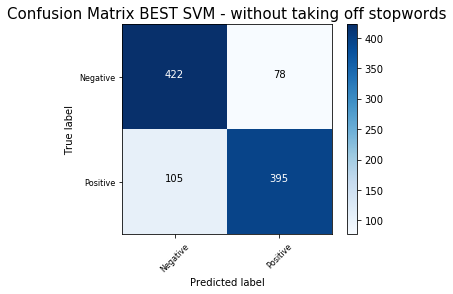

In [36]:
y_pred_SVM_cross_stopwords = cross_val_predict(classifier_svm_cross_stop, X_stop, y_stop, cv=10) # 10 CV
cm = confusion_matrix(y_stop, y_pred_SVM_cross_stopwords)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                      title='Confusion Matrix BEST SVM - without taking off stopwords')

### TENTATIVA PARA MELHORAR O MODELO ATRAVÉS DE OUTRA LISTA DE STOPWORDS:
* Seleção de outra lista de stopwords;
* Neste lista não estão as palavras (tokens) que tem conotação negativa;
* Palavras (tokens) negativos serão considerados pelo classificador;
* Tentativa de utilizar também um corretor de contrações (por exemplo: "didn't" se transforma em "did not").


* LINKS:
* https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html
* https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
* https://github.com/kootenpv/contractions

In [37]:
stopword_v1=[]
xls = pd.ExcelFile('stopword_v1.xlsx')
sheet_stop = xls.parse(0)
stopword_v1=sheet_stop['WORDS'].str.lower().tolist()


def text_process_stopword(data):
    corpus=[]
    for text in data:
        text=re.sub("[^a-zA-Z]"," ", text)   
        text=text.lower()
        text=strip_accents(text)
        ps = PorterStemmer() 
        word=[str(ps.stem(word)) for word in text.split() if word not in set(stopword_v1)]
        word = ' '.join(word)
        corpus.append(word)
    
    return corpus


text_stop=text_process_stopword(data['Review'])

cv = CountVectorizer()
X_stop = cv.fit_transform(text_stop).toarray()
y_stop = data.iloc[:, 1].values

classifier_svm_cross_stop = SVC(kernel='rbf',C=100,gamma=0.001)

scores_SVM_stopwords1= cross_val_score(classifier_svm_cross_stop,X_stop, y_stop, scoring='accuracy', cv=10)
print("Accuracies: " + str(scores_SVM_stopwords1))
print("\nAccuracy for SVM with stopword list 1: %0.2f \n" % (scores_SVM_stopwords1.mean()))



Accuracies: [ 0.82  0.83  0.78  0.81  0.8   0.86  0.86  0.83  0.83  0.88]

Accuracy for SVM with stopword list 1: 0.83 



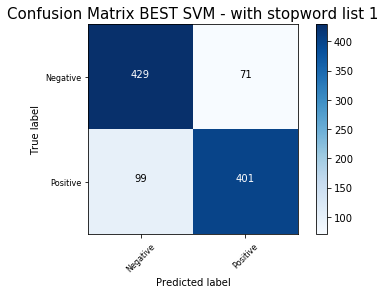

In [38]:
y_pred_SVM_cross_stopwords1 = cross_val_predict(classifier_svm_cross_stop, X_stop, y_stop, cv=10) # 10 CV
cm = confusion_matrix(y_stop, y_pred_SVM_cross_stopwords1)

plt.figure()
plot_confusion_matrix(cm, classes=['Negative', 'Positive'],
                      title='Confusion Matrix BEST SVM - with stopword list 1')

### GRIDSEARCH PARA NOVO PRE-PROCESSAMENTO:
* Como as etapas de pre-processamento mudaram pode ser que os melhores hiperparâmetros tenham mudado.

#### GRIDSEARCH PARA O SVM:

In [39]:
from sklearn.grid_search import GridSearchCV

parameter_grid = [
  {'C': [1,10,100,1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'degree':[2,3,4], 'kernel': ['poly']}
]

clf = GridSearchCV(estimator=SVC(), param_grid=parameter_grid,cv=10, n_jobs=-1)
clf.fit(X_stop, y_stop)

print('Grid Scores:\n',clf.grid_scores_)
best_score=clf.best_score_
best_params=clf.best_params_
best_estimator=clf.best_estimator_
print('Best score:\n ', clf.best_score_)
print('Best params:\n ', clf.best_params_)
print('Best estimator:\n ', clf.best_estimator_)

Grid Scores:
 [mean: 0.82400, std: 0.01960, params: {'C': 1, 'kernel': 'linear'}, mean: 0.79200, std: 0.03709, params: {'C': 10, 'kernel': 'linear'}, mean: 0.79000, std: 0.02408, params: {'C': 100, 'kernel': 'linear'}, mean: 0.78300, std: 0.03195, params: {'C': 1000, 'kernel': 'linear'}, mean: 0.71800, std: 0.03945, params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.71100, std: 0.04085, params: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.77800, std: 0.05154, params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.71100, std: 0.04085, params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.83000, std: 0.02864, params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.77800, std: 0.04833, params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.80900, std: 0.01921, params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.82800, std: 0.02522, params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.59800, std: 0.04976, params: {'C': 1, 'degree':

#### GRIDSEARCH PARA O RANDOM FOREST:

In [40]:
parameter_grid = [
  {'n_estimators': np.arange(1,201,25),'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']}]

clf = GridSearchCV(estimator= RandomForestClassifier(), param_grid=parameter_grid,cv=10, n_jobs=-1)
clf.fit(X_stop, y_stop)

print('Grid Scores:\n',clf.grid_scores_)
best_score=clf.best_score_
best_params=clf.best_params_
best_estimator=clf.best_estimator_
print('Best score:\n ', clf.best_score_)
print('Best params:\n ', clf.best_params_)
print('Best estimator:\n ', clf.best_estimator_)

Grid Scores:
 [mean: 0.71800, std: 0.05325, params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1}, mean: 0.79400, std: 0.04247, params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 26}, mean: 0.81100, std: 0.03986, params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 51}, mean: 0.82000, std: 0.04074, params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 76}, mean: 0.81400, std: 0.03470, params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 101}, mean: 0.81200, std: 0.03842, params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 126}, mean: 0.82200, std: 0.03311, params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 151}, mean: 0.82500, std: 0.03294, params: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 176}, mean: 0.75500, std: 0.04588, params: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1}, mean: 0.81000, std: 0.05158, params: {'criterio

### COMPARAÇÃO DOS RESULTADOS DE TODOS OS CLASSIFICADORES:
* Todos com o mesmo pre-processamento e com cross-validate.

In [41]:
RandForest_comp =RandomForestClassifier(criterion= 'gini', max_features= 'log2', n_estimators = 176)
MultiNB_comp= MultinomialNB()
SVM_rbf_comp = SVC(kernel='rbf',C=100,gamma=0.001)
gaussianNB_comp = GaussianNB()
SVM_linear_comp = SVC(kernel='linear',C=1)

My_classifiers = [('Random Forest', RandForest_comp), ('Multinominal Naive Bayes',MultiNB_comp),
                  ('Support Vector Machine (kernel RBF)',SVM_rbf_comp), 
                  ('Gaussian Naive Bayes',gaussianNB_comp),
                  ('Support Vector Machine (kernel Linear)', SVM_linear_comp)]


dict_class_cross={}
for classifiers in My_classifiers:
    scores= cross_val_score(classifiers[1], X_stop, y_stop, cv=10)
    dict_class_cross[str(classifiers[0])] = scores.mean()
    print("Accuracy for "+ str(classifiers[0])+ ": " + str(scores.mean()))
    y_pred= cross_val_predict(classifiers[1],X_stop,y_stop,cv=10)
    print ('Classification Report for'+ str(classifiers[0])+':\n',classification_report(y_stop,y_pred))
    print('\n\n')
    
    

Accuracy for Random Forest: 0.822
Classification Report forRandom Forest:
              precision    recall  f1-score   support

   NEGATIVE       0.82      0.83      0.83       500
   POSITIVE       0.83      0.82      0.82       500

avg / total       0.83      0.82      0.82      1000




Accuracy for Multinominal Naive Bayes: 0.8
Classification Report forMultinominal Naive Bayes:
              precision    recall  f1-score   support

   NEGATIVE       0.80      0.81      0.80       500
   POSITIVE       0.80      0.79      0.80       500

avg / total       0.80      0.80      0.80      1000




Accuracy for Support Vector Machine (kernel RBF): 0.83
Classification Report forSupport Vector Machine (kernel RBF):
              precision    recall  f1-score   support

   NEGATIVE       0.81      0.86      0.83       500
   POSITIVE       0.85      0.80      0.83       500

avg / total       0.83      0.83      0.83      1000




Accuracy for Gaussian Naive Bayes: 0.682
Classification Re

#### VOTAÇÃO DE CLASSIFICADORES:
* Combinar diferentes classificadores de Machine Learning e usar a "maiora" ou probabilidades médias preditas (soft vote) para predição da categoria (label) da classe;
* Classificador útil para um conjunto de classificadores com desempenho (performance) igualmente boa;
* Balancea a fraqueza de cada classificador.

#### PARA VOTING = HARD:

![title](voting_classifier.png)


* LINK:
* http://scikit-learn.org/stable/modules/ensemble.html

In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

RandForest_vt =RandomForestClassifier(criterion= 'gini', max_features= 'log2', n_estimators = 176)
MultiNB_vt= MultinomialNB()
SVM_svc_vt = SVC(kernel='linear',C=1)

Estimators_Vote= [('Random Forest', RandForest_vt), ('Multinominal Naive Bayes',MultiNB_vt)
                                     , ('Support Vector Machine (SVM)',SVM_svc_vt)]

Voting_classifier = VotingClassifier(estimators= Estimators_Vote,voting='hard')



In [43]:
#https://stackoverflow.com/questions/48687375/deprecation-error-in-sklearn-about-empty-array-without-any-empty-array-in-my-cod
#https://stackoverflow.com/questions/879173/how-to-ignore-deprecation-warnings-in-python

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

scores_vt= cross_val_score(Voting_classifier,X_stop,y_stop, scoring='accuracy',cv=10)
print("Accuracies for Voting Classifier: ", scores_vt)
print("\nAccuracy for Voting Classifier:  %0.2f +/- %0.2f \n" % (scores_vt.mean(), scores_vt.std()*2))

f1_vt= cross_val_score(Voting_classifier,X_stop,y_stop, scoring='f1_weighted',cv=10)
print("F1-measure for Voting Classifier: ", scores_vt)
print("\nF1-measure for Voting Classifier:  %0.2f +/- %0.2f \n" % (f1_vt.mean(), f1_vt.std()*2))

dict_class_cross['Voting Classifier'] = scores_vt.mean()

Accuracies for Voting Classifier:  [ 0.84  0.85  0.83  0.83  0.78  0.84  0.82  0.84  0.83  0.83]

Accuracy for Voting Classifier:  0.83 +/- 0.04 

F1-measure for Voting Classifier:  [ 0.84  0.85  0.83  0.83  0.78  0.84  0.82  0.84  0.83  0.83]

F1-measure for Voting Classifier:  0.83 +/- 0.05 



In [44]:
plot_acc = pd.DataFrame(list(dict_class_cross.items()), columns=['Name','Accuracy'])
plot_acc

,Name,Accuracy
0,Random Forest,0.822
1,Multinominal Naive Bayes,0.800
2,Support Vector Machine (kernel RBF),0.830
3,Gaussian Naive Bayes,0.682
4,Support Vector Machine (kernel Linear),0.824
5,Voting Classifier,0.829


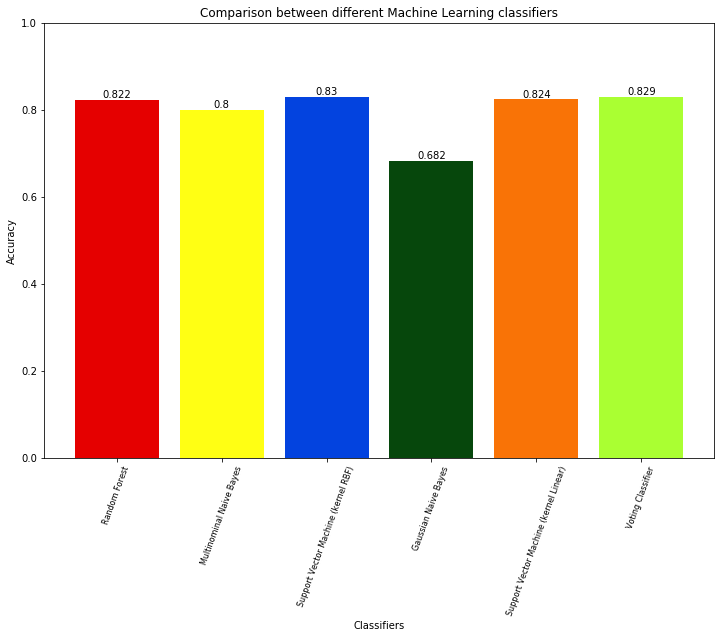

In [45]:
# https://blog.xkcd.com/2010/05/03/color-survey-results/
classifiers = list(dict_class_cross.keys())
accuracy = list(dict_class_cross.values())
plt.figure(figsize=(12,8))

pm, pc, pn,pv,pk,pq = plt.bar(left=range(len(dict_class_cross)),height=accuracy,tick_label=classifiers)
pm.set_facecolor('#e50000')
pc.set_facecolor('#ffff14')
pn.set_facecolor('#0343df')
pv.set_facecolor('#06470c')
pk.set_facecolor('#f97306')
pq.set_facecolor('#aaff32')
plt.ylim(ymax=1)
plt.ylabel('Accuracy',fontsize=10)
plt.xlabel('Classifiers',fontsize=10)
plt.xticks(rotation=70,fontsize=8)
plt.title('Comparison between different Machine Learning classifiers',fontsize=12)



i=0
for txt in accuracy:
    plt.annotate(round(txt, 3),(i,round(txt, 3)+0.005),ha="center")
    i+=1
    
plt.show()